In [2]:
import numpy as np
import pandas as pd

import os
import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18, resnet50
import torch.nn as nn
import torch.nn.functional as F

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.miners import BaseMiner

from sklearn.metrics import pairwise_distances

from online_triplet_loss.losses import *


from tqdm.notebook import tqdm

from PIL import Image
import random



from matplotlib import pyplot as plt
import seaborn as sns

import warnings

import logging

warnings.filterwarnings("ignore")

In [3]:
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.2.0


### Prepare dataframe

In [3]:
df_train = pd.read_csv("Stanford_Online_Products/Ebay_train.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

In [4]:
df_train

,image_id,class_id,super_class_id,path
0,1,1,1,bicycle_final/111085122871_0.JPG
1,2,1,1,bicycle_final/111085122871_1.JPG
2,3,1,1,bicycle_final/111085122871_2.JPG
3,4,1,1,bicycle_final/111085122871_3.JPG
4,5,1,1,bicycle_final/111085122871_4.JPG
...,...,...,...,...
59546,59547,11318,12,toaster_final/221852410489_0.JPG
59547,59548,11318,12,toaster_final/221852410489_1.JPG
59548,59549,11318,12,toaster_final/221852410489_2.JPG
59549,59550,11318,12,toaster_final/221852410489_3.JPG


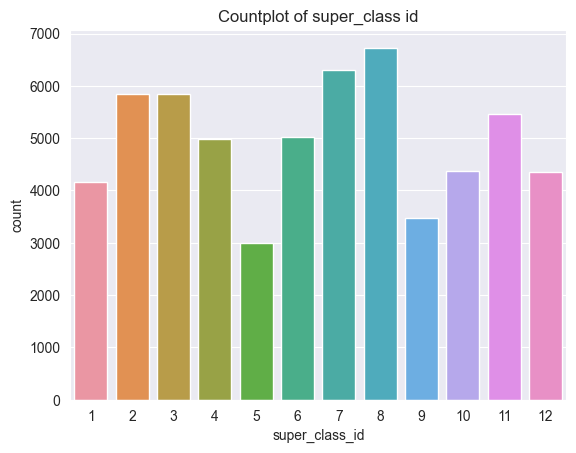

In [5]:
plt.title("Countplot of super_class id")
sns.countplot(data=df_train, x='super_class_id')
plt.show()

In [6]:
PATH = "Stanford_Online_Products"
IMAGE_SIZE = 224

In [8]:
class ProductDataset(Dataset):
    def __init__(self, df, path, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        if self.is_train:
            self.images = df["path"].values
            self.labels = df["class_id"].values
            self.index = df.index.values



    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        anchor_image_path = self.path + "/" + anchor_image_name
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert("RGB")
        if self.is_train:
            anchor_label = self.labels[item]
            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_image_name = self.images[positive_item]
            positive_image_path = self.path + "/" + positive_image_name
            positive_img = Image.open(positive_image_path).convert("RGB")
            #positive_img = self.images[positive_item].reshape(28, 28, 1)
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_image_name = self.images[negative_item]
            negative_image_path = self.path + "/" +  negative_image_name
            negative_img = Image.open(negative_image_path).convert("RGB")
            #negative_img = self.images[negative_item].reshape(28, 28, 1)

        if self.transform != None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label





train_transform =transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [17]:
class ProductDataset(Dataset):
    def __init__(self, df, path, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        if self.is_train:
            self.images = df["path"].values
            self.labels = df["class_id"].values
            self.index = df.index.values



    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        anchor_image_path = self.path + "/" + anchor_image_name
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert("RGB")
        if self.is_train:
            anchor_label = self.labels[item]


        if self.transform != None:
            anchor_img = self.transform(anchor_img)


        return anchor_img, anchor_label





train_transform =transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [18]:
trainDS = ProductDataset(df=df_train, path=PATH, train=True, transform=train_transform)

In [19]:
BATCH_SIZE = 64

In [20]:
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
# anchors, positives, negatives, labels = next(iter(trainLoader))

In [22]:
images, labels = next(iter(trainLoader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


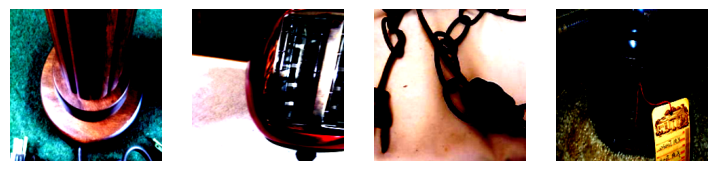

In [31]:
plt.figure(figsize=(9, 40))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis("off")
plt.show()

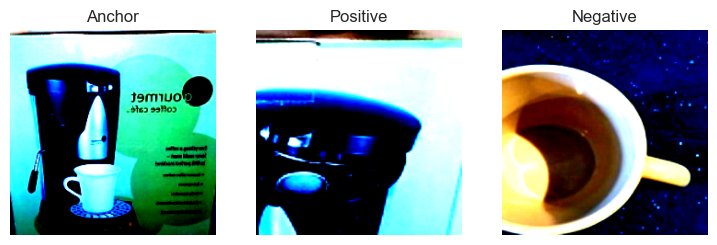

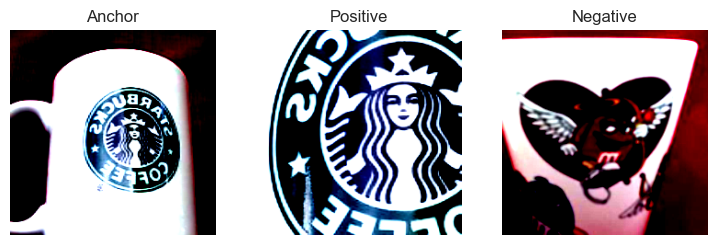

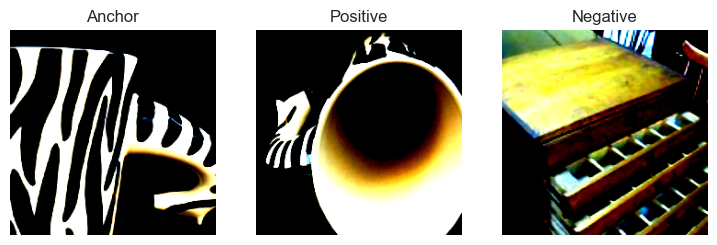

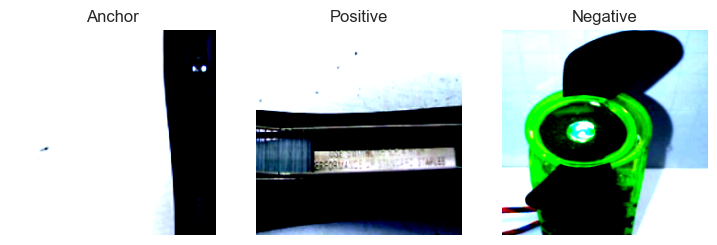

In [13]:
# for i in range(4):
#
#     plt.figure(figsize=(9,18))
#     plt.subplot(1,3,1)
#     plt.imshow(anchors[i].permute(1, 2, 0))
#     plt.axis("off")
#     plt.title("Anchor")
#
#     plt.subplot(1,3,2)
#     plt.imshow(positives[i].permute(1, 2, 0))
#     plt.axis("off")
#     plt.title("Positive")
#
#     plt.subplot(1,3,3)
#     plt.imshow(negatives[i].permute(1, 2, 0))
#     plt.axis("off")
#     plt.title("Negative")
#
#     plt.show()

In [32]:
EMBED_DIMS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0001
EPOCHS = 10

In [33]:
class ResNet_Triplet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet18(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.ReLU(),
                  nn.Linear(512,EMBED_DIMS))


    def forward(self,x):
        x = self.Feature_Extractor(x)
        x = F.normalize(x, p=2, dim=1, eps=1.e-8)

        return x

In [34]:
model = ResNet_Triplet()
# model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)

In [29]:
# Set the loss function
criterion = losses.TripletMarginLoss(margin=0.1)

In [35]:
miner = miners.BatchEasyHardMiner(
        pos_strategy="hard",
        neg_strategy="hard",
        allowed_pos_range=None,
        allowed_neg_range=None)

In [36]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)
# dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"

In [37]:
models = {"trunk": model, "embedder": None}
optimizers = {
    "trunk_optimizer": optimizer,
    "embedder_optimizer": None
}
loss_funcs = {"metric_loss": criterion}
mining_funcs = {"tuple_miner": miner}

In [38]:
trainer =trainers.BaseTrainer(models = models,
                    optimizers = optimizers,
                    batch_size = BATCH_SIZE,
                    loss_funcs = loss_funcs,
                    dataset = trainDS,
                    mining_funcs=mining_funcs,
                    dataloader_num_workers=2,
                    end_of_iteration_hook=hooks.end_of_iteration_hook
)

In [39]:
%load_ext tensorboard
%tensorboard --logdir example_tensorboard

Launching TensorBoard...

In [ ]:
trainer.train(num_epochs=EPOCHS)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator


In [ ]:
for epoch in tqdm(range(EPOCHS)):
    running_loss = []
    for step, (images, labels) in enumerate(tqdm(trainLoader)):

        embeddings = model(images)
        optimizer.zero_grad()

        loss, fraction_pos = batch_all_triplet_loss(labels, embeddings, squared=False, margin=1.0)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/931 [00:00<?, ?it/s]

In [ ]:
torch.save(model, "models/model.pts")